## TECHNICAL TEST  - METRODATA

PT ABC adalah perusahaan yang bergerak di bidang produksi roti. Hasil produksi didistibusikan ke berbagai outlet atau store rekanan. Perusahaan tersebut kerap mengalami masalah karena banyak roti yang tidak terjual, sehingga produk retur karena kedalursa cukup banyak. Anda sebagai Data Scientist diminta untuk memberikan solusi berbasis machine learning yang dapat memberikan rekomendasi berupa jumlah unit roti atau order quantity yang sebaiknya dititipkan ke setiap outlet. Gunakan dataset terlampir dan lakukan demand forecasting per store secara harian. Point yg dinilai berupa presentasi hasil yang memuat:
1.	Hasil forecast untuk demand selama 7 hari dan 30 hari kedepan
2.	Penjelasan workflow machine learning yang dibuat
3.	Gunakan 2 jenis algoritma yaitu Time series dan Regresi dan masing-masing algoritma gunakan minimal 2 alternatif model
4.	Summary model performance 

In [2]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

%matplotlib inline
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

# Set seeds to make the experiment more reproducible.
from tensorflow import set_random_seed
from numpy.random import seed
set_random_seed(1)
seed(1)

ModuleNotFoundError: No module named 'tensorflow'

In [82]:
# Read excel dataset
df = pd.read_excel("../raw/dataset.xls")

In [83]:
df.head()

,date,order_qty,product_id,store
0,20180626,0.416667,A1,7079
1,20180626,0.416667,A1,7088
2,20180609,0.208333,B2,7081
3,20180609,0.041667,B2,7081
4,20180609,0.041667,B2,7081


In [84]:
# Check missing values
df.isnull().sum()

date          0
order_qty     0
product_id    0
store         0
dtype: int64

In [85]:
# Check the type of columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17121 entries, 0 to 17120
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        17121 non-null  int64  
 1   order_qty   17121 non-null  float64
 2   product_id  17121 non-null  object 
 3   store       17121 non-null  int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 535.2+ KB


In [ ]:
# Typcasting date from "int" into "str" and change format into datetime
df['date'] = df['date'].astype('string')
df['date'] = pd.to_datetime(df['date'])

df.info()

In [89]:
# Set index from date column
df.set_index('date', inplace=True)

In [113]:
df = df.sort_index()

In [157]:
# Typcasting store from "int" into "str"
df['store'] = df['store'].astype('string')

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17121 entries, 2016-08-01 to 2018-12-01
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   order_qty   17121 non-null  float64
 1   product_id  17121 non-null  object 
 2   store       17121 non-null  string 
 3   year        17121 non-null  int32  
 4   month       17121 non-null  int32  
 5   day         17121 non-null  int32  
 6   weekday     17121 non-null  int32  
dtypes: float64(1), int32(4), object(1), string(1)
memory usage: 802.5+ KB


In [115]:
df['year'] =  df.index.year
df['month'] =  df.index.month
df['day'] =  df.index.day
df['weekday'] =  df.index.weekday

df.head()

,order_qty,product_id,store,year,month,day,weekday
date,,,,,,,
2016-08-01,0.708333,E5,7079,2016,8,1,0
2016-08-01,0.791667,E5,7088,2016,8,1,0
2016-08-01,12.500000,E5,7079,2016,8,1,0
2016-08-01,1.041667,E5,7088,2016,8,1,0
2016-08-01,0.416667,E5,7088,2016,8,1,0


In [116]:
df.describe()

,order_qty,year,month,day,weekday
count,17121.000000,17121.000000,17121.000000,17121.000000,17121.000000
mean,0.669138,2017.184569,6.749781,10.202558,2.188248
std,1.446521,0.673634,3.471059,8.682535,1.674895
min,0.000000,2016.000000,1.000000,1.000000,0.000000
25%,0.083333,2017.000000,4.000000,2.000000,1.000000
50%,0.208333,2017.000000,7.000000,8.000000,2.000000
75%,0.625000,2018.000000,10.000000,17.000000,3.000000
max,25.000000,2018.000000,12.000000,31.000000,6.000000


In [117]:
df['product_id'].unique()

array(['E5', 'B2', 'G7', 'A1', 'C3', 'D4', 'F6'], dtype=object)

In [118]:
df['store'].unique()

<StringArray>
['7079', '7088', '7084', '7081', '7082']
Length: 5, dtype: string

In [119]:
min_date = df.index.min()
max_date = df.index.max()
# diff_date = max_date - max_date

print(f"Tanggal mulai : {min_date}")
print(f"Tanggal akhir : {max_date}")
# print(f"Rentang waktu : {diff_date}")

Tanggal mulai : 2016-08-01 00:00:00
Tanggal akhir : 2018-12-01 00:00:00


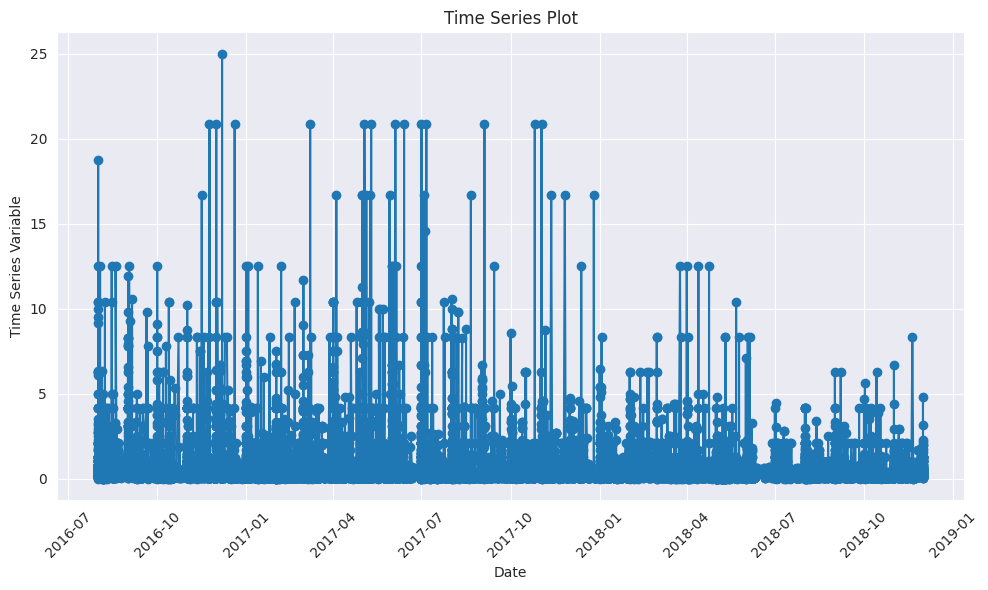

In [120]:
# Plot for "Daily" order
# Example DataFrame creation with datetime index
df_daily_plot = df.sort_index()

# Plotting
plt.figure(figsize=(10, 6))  # Optional: Set the figure size

# Plot the time series variable
plt.plot(df_daily_plot.index, df_daily_plot['order_qty'], marker='o', linestyle='-')

# Optional: Customize the plot (labels, title, etc.)
plt.xlabel('Date')
plt.ylabel('Time Series Variable')
plt.title('Time Series Plot')
plt.grid(True)  # Add grid
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Show the plot
plt.tight_layout()  # Optional: Adjust layout to prevent clipping of labels
plt.show()


## Decompose Time Series 

<Axes: xlabel='date', ylabel='order_qty'>

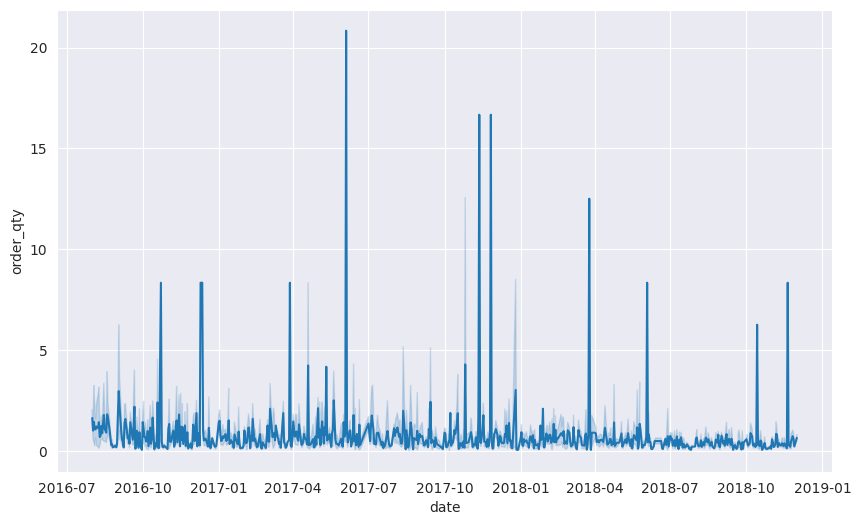

In [121]:
plt.figure(figsize=(10, 6))
sns.lineplot(x="date", y="order_qty",legend = 'full' , data=df)

<Axes: xlabel='date', ylabel='order_qty'>

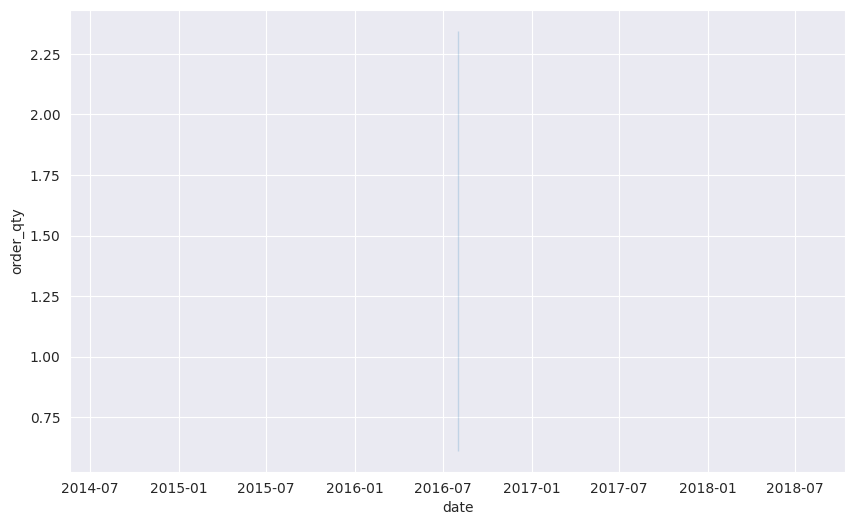

In [125]:
plt.figure(figsize=(10, 6))
sns.lineplot(x="date", y="order_qty",legend = 'full' , data=df[:28])

<Axes: xlabel='weekday', ylabel='order_qty'>

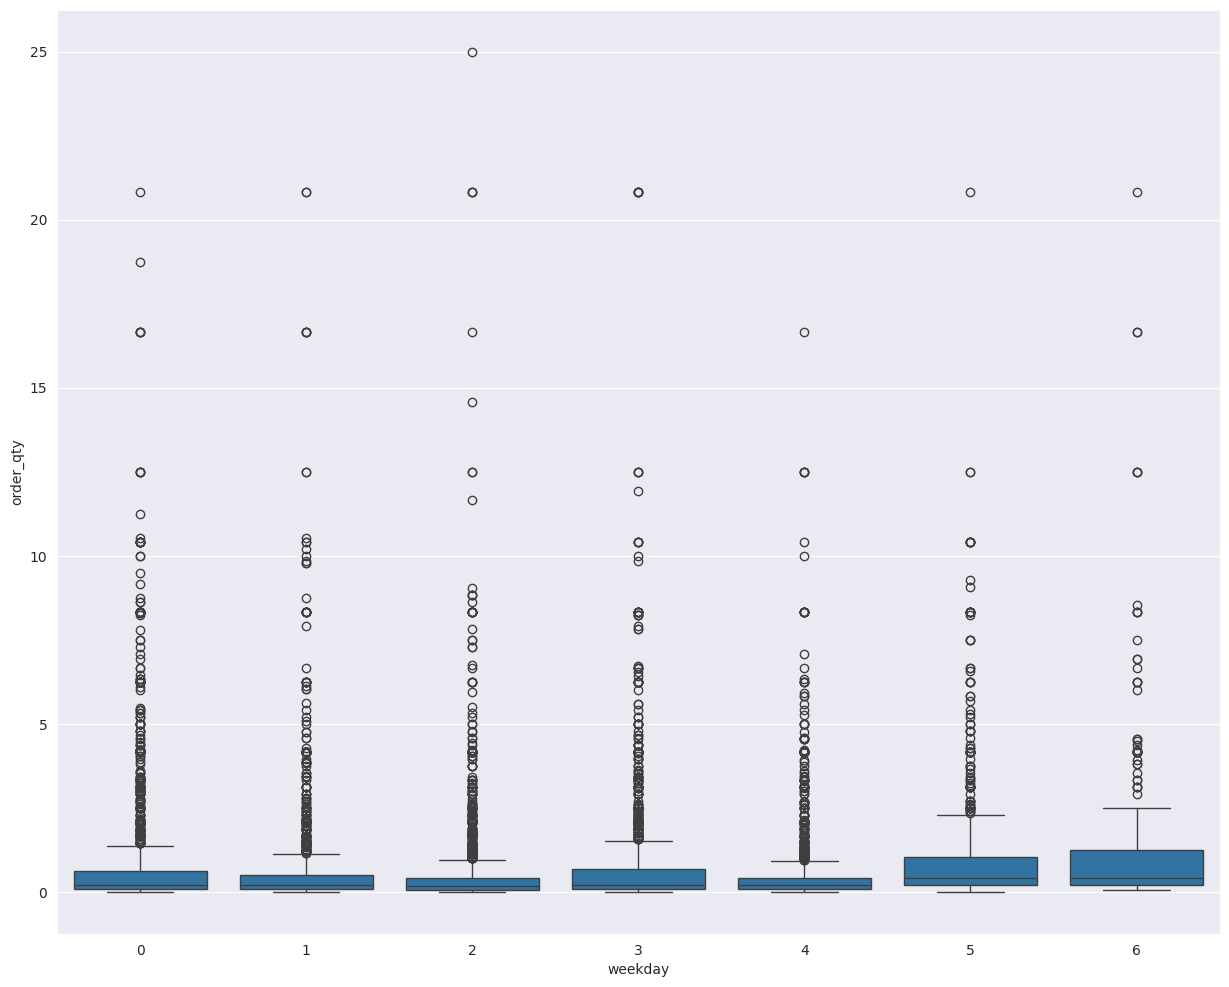

In [123]:
plt.figure(figsize=(15, 12))
sns.boxplot(x="weekday", y="order_qty", data=df)

<Figure size 640x480 with 0 Axes>

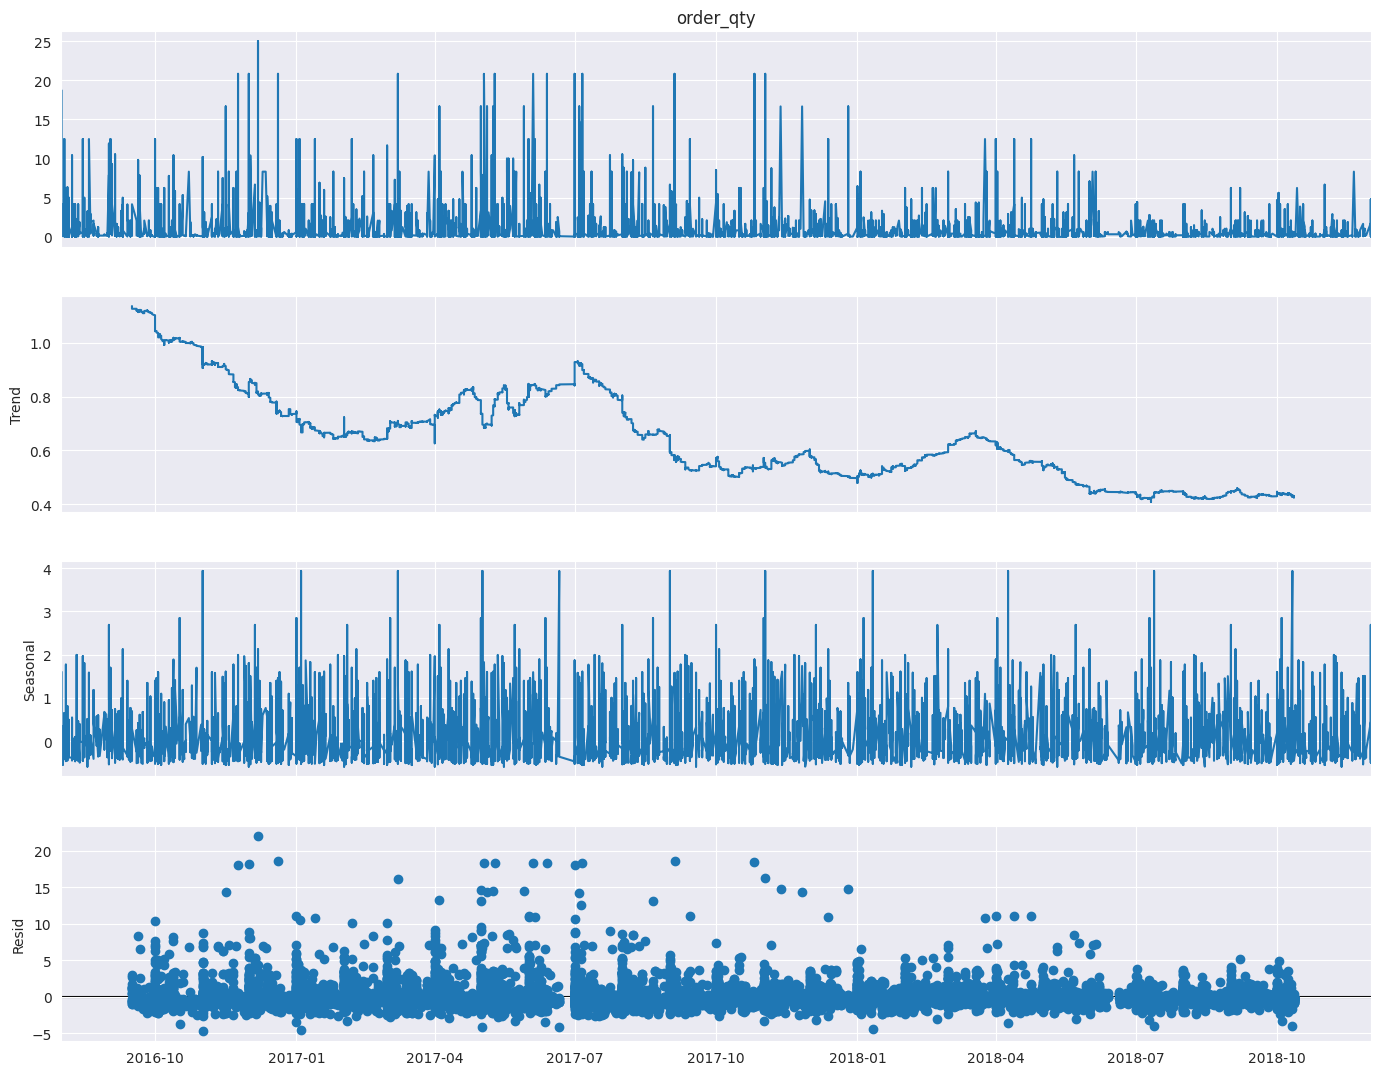

In [185]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df['order_qty'], model='additive', period = 1500)

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 12)

## Stationarize the data

In [127]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window = 12, cutoff = 0.01):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

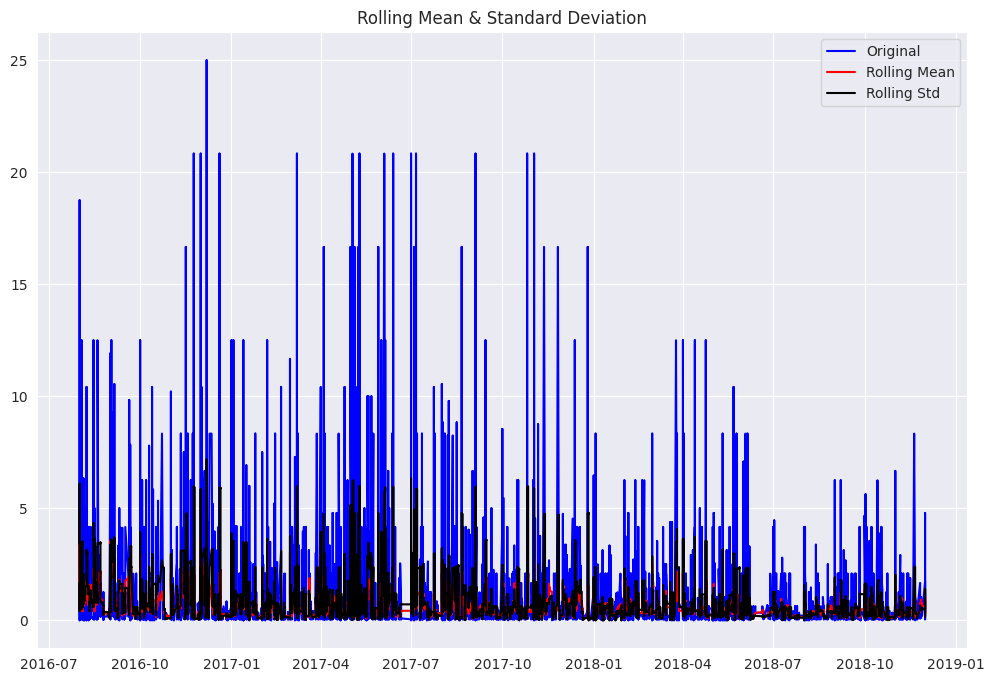

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                   -19.760873
p-value                            0.000000
#Lags Used                        20.000000
Number of Observations Used    17100.000000
Critical Value (1%)               -3.430732
Critical Value (5%)               -2.861709
Critical Value (10%)              -2.566860
dtype: float64


In [128]:
test_stationarity(df['order_qty'])

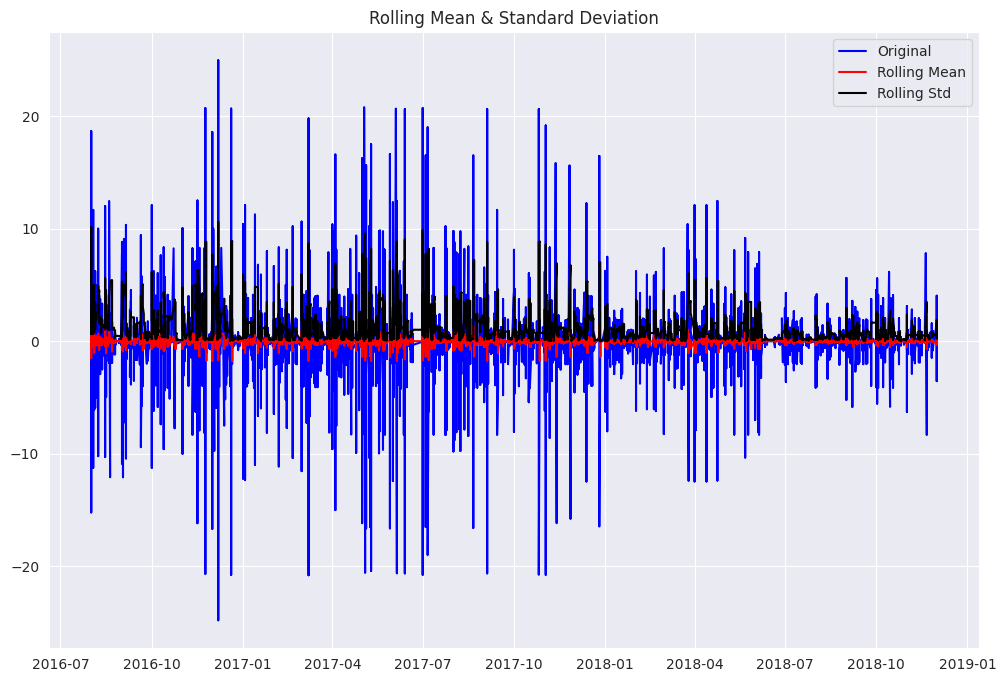

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                   -47.726979
p-value                            0.000000
#Lags Used                        20.000000
Number of Observations Used    17099.000000
Critical Value (1%)               -3.430732
Critical Value (5%)               -2.861709
Critical Value (10%)              -2.566860
dtype: float64


In [135]:
first_diff = df.order_qty - df.order_qty.shift(1)
first_diff = first_diff.dropna(inplace = False)
test_stationarity(first_diff, window = 12)

## ACF & PACF

The partial autocorrelation at lag k is the correlation that results after removing the effect of any correlations due to the terms at shorter lags.

Autoregression Intuition
Consider a time series that was generated by an autoregression (AR) process with a lag of k.

We know that the ACF describes the autocorrelation between an observation and another observation at a prior time step that includes direct and indirect dependence information.

This means we would expect the ACF for the AR(k) time series to be strong to a lag of k and the inertia of that relationship would carry on to subsequent lag values, trailing off at some point as the effect was weakened.

We know that the PACF only describes the direct relationship between an observation and its lag. This would suggest that there would be no correlation for lag values beyond k.

This is exactly the expectation of the ACF and PACF plots for an AR(k) process.

Moving Average Intuition
Consider a time series that was generated by a moving average (MA) process with a lag of k.

Remember that the moving average process is an autoregression model of the time series of residual errors from prior predictions. Another way to think about the moving average model is that it corrects future forecasts based on errors made on recent forecasts.

We would expect the ACF for the MA(k) process to show a strong correlation with recent values up to the lag of k, then a sharp decline to low or no correlation. By definition, this is how the process was generated.

For the PACF, we would expect the plot to show a strong relationship to the lag and a trailing off of correlation from the lag onwards.

Again, this is exactly the expectation of the ACF and PACF plots for an MA(k) process.

Summary
From the autocorrelation plot we can tell whether or not we need to add MA terms. From the partial autocorrelation plot we know we need to add AR terms.

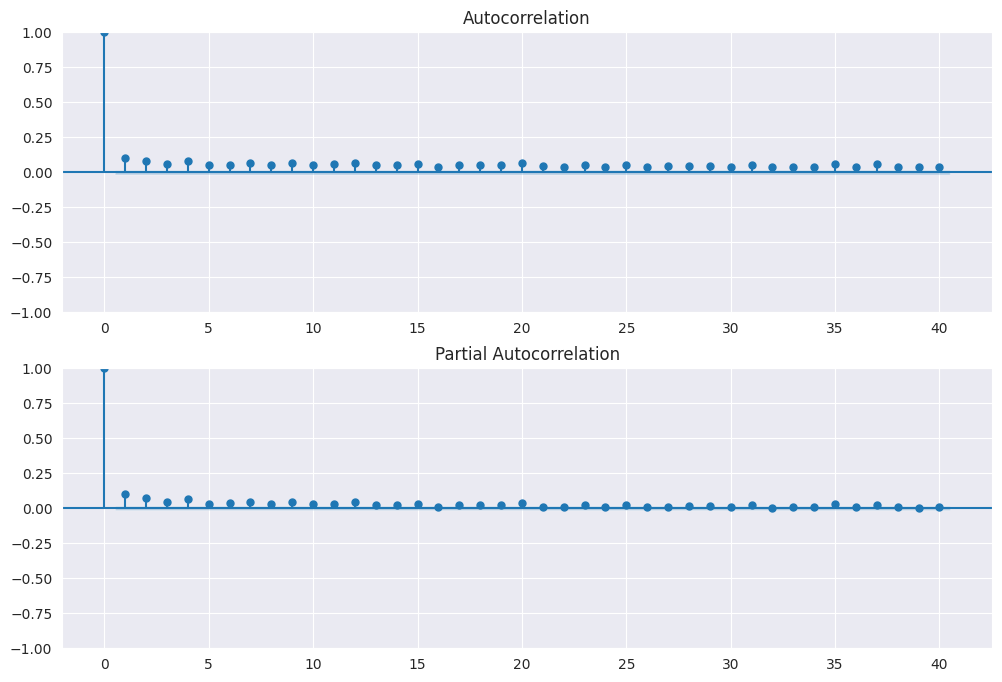

In [139]:
import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df.order_qty, lags=40, ax=ax1) # 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df.order_qty, lags=40, ax=ax2)# , lags=40

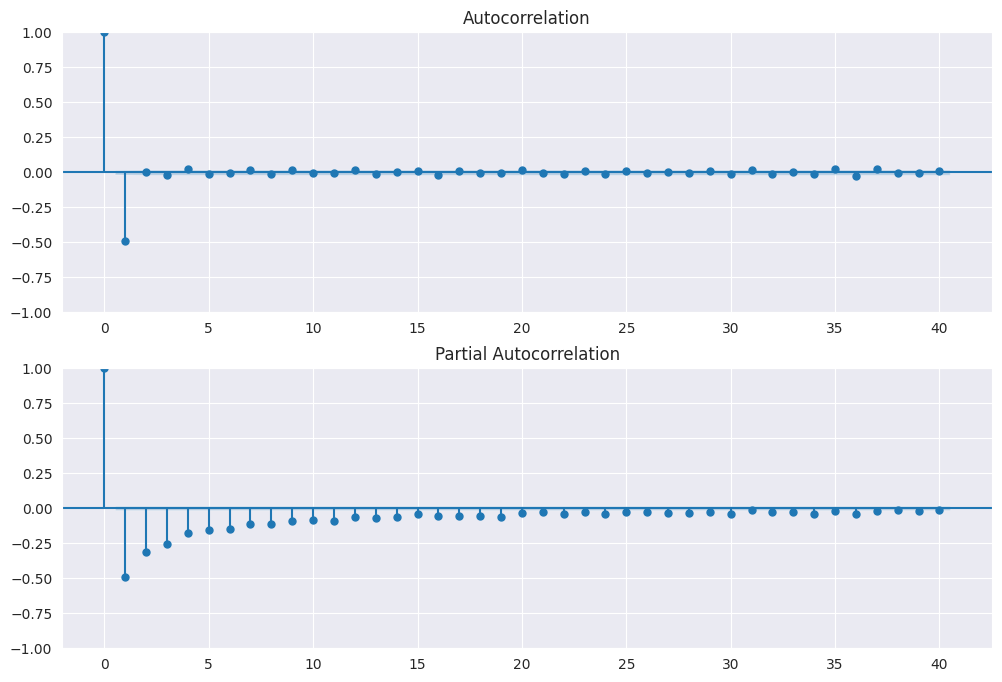

In [140]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(first_diff, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(first_diff, lags=40, ax=ax2)

Because the autocorrelation of the differenced series is negative at lag 7, 14, 21 etc.. (every week), I should an SMA term to the model.

Build the model

How to determin p, d, q
It's easy to determin I. In our case, we see the first order differencing make the ts stationary. I = 1.

AR model might be investigated first with lag length selected from the PACF or via empirical investigation. In our case, it's clearly that within 6 lags the AR is significant. Which means, we can use AR = 6

To avoid the potential for incorrectly specifying the MA order (in the case where the MA is first tried then the MA order is being set to 0), it may often make sense to extend the lag observed from the last significant term in the PACF.

What is interesting is that when the AR model is appropriately specified, the the residuals from this model can be used to directly observe the uncorrelated error. This residual can be used to further investigate alternative MA and ARMA model specifications directly by regression.

Assuming an AR(s) model were computed, then I would suggest that the next step in identification is to estimate an MA model with s-1 lags in the uncorrelated errors derived from the regression. The parsimonious MA specification might be considered and this might be compared with a more parsimonious AR specification. Then ARMA models might also be analysed.

In [155]:
arima_mod6 = sm.tsa.ARIMA(df.order_qty, (0,1,0)).fit(disp=False)
print(arima_mod6.summary())

ValueError: endog and exog matrices are different sizes

In [154]:
from scipy import stats
from scipy.stats import normaltest

resid = arima_mod6.resid
print(normaltest(resid))
# returns a 2-tuple of the chi-squared statistic, and the associated p-value. the p-value is very small, meaning
# the residual is not a normal distribution

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(resid)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')


# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arima_mod6.resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arima_mod6.resid, lags=40, ax=ax2)

NameError: name 'arima_mod6' is not defined

In [158]:
df['product_id'].unique()

array(['E5', 'B2', 'G7', 'A1', 'C3', 'D4', 'F6'], dtype=object)

In [159]:
# Split dataframe for each product_id
g = globals()

for product in df['product_id'].unique():
    g[f'df_{product}'] = df[df['product_id'] == product].sort_index()
    print(f'Total rows in df_{product} :', len(g[f'df_{product}']))

Total rows in df_E5 : 9255
Total rows in df_B2 : 3744
Total rows in df_G7 : 448
Total rows in df_A1 : 1431
Total rows in df_C3 : 221
Total rows in df_D4 : 1355
Total rows in df_F6 : 667


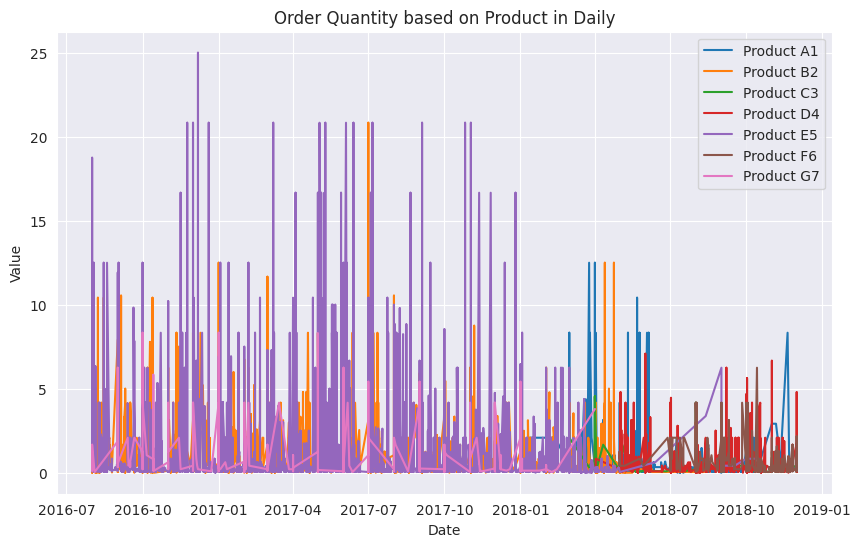

In [160]:
# Plot for "Daily" order
# Create Matplotlib figure and axes
plt.figure(figsize=(10, 6))
plt.plot(df_A1.index, df_A1['order_qty'], label='Product A1')
plt.plot(df_B2.index, df_B2['order_qty'], label='Product B2')
plt.plot(df_C3.index, df_C3['order_qty'], label='Product C3')
plt.plot(df_D4.index, df_D4['order_qty'], label='Product D4')
plt.plot(df_E5.index, df_E5['order_qty'], label='Product E5')
plt.plot(df_F6.index, df_F6['order_qty'], label='Product F6')
plt.plot(df_G7.index, df_G7['order_qty'], label='Product G7')

# Customize the plot
plt.title('Order Quantity based on Product in Daily')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()

# Show the plot
plt.show()

### df_A1

## Decompose Time Series 

<Axes: xlabel='date', ylabel='order_qty'>

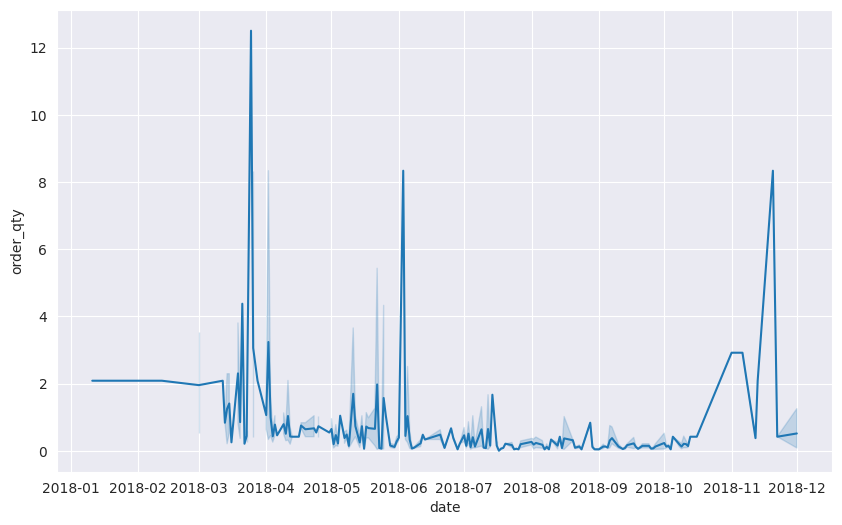

In [161]:
plt.figure(figsize=(10, 6))
sns.lineplot(x="date", y="order_qty",legend = 'full' , data=df_A1)

<Axes: xlabel='date', ylabel='order_qty'>

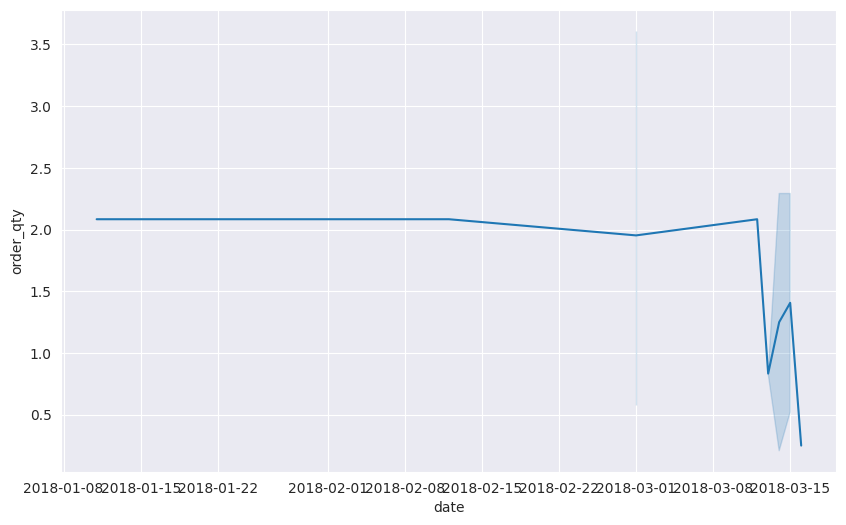

In [162]:
plt.figure(figsize=(10, 6))
sns.lineplot(x="date", y="order_qty",legend = 'full' , data=df_A1[:28])

<Axes: xlabel='weekday', ylabel='order_qty'>

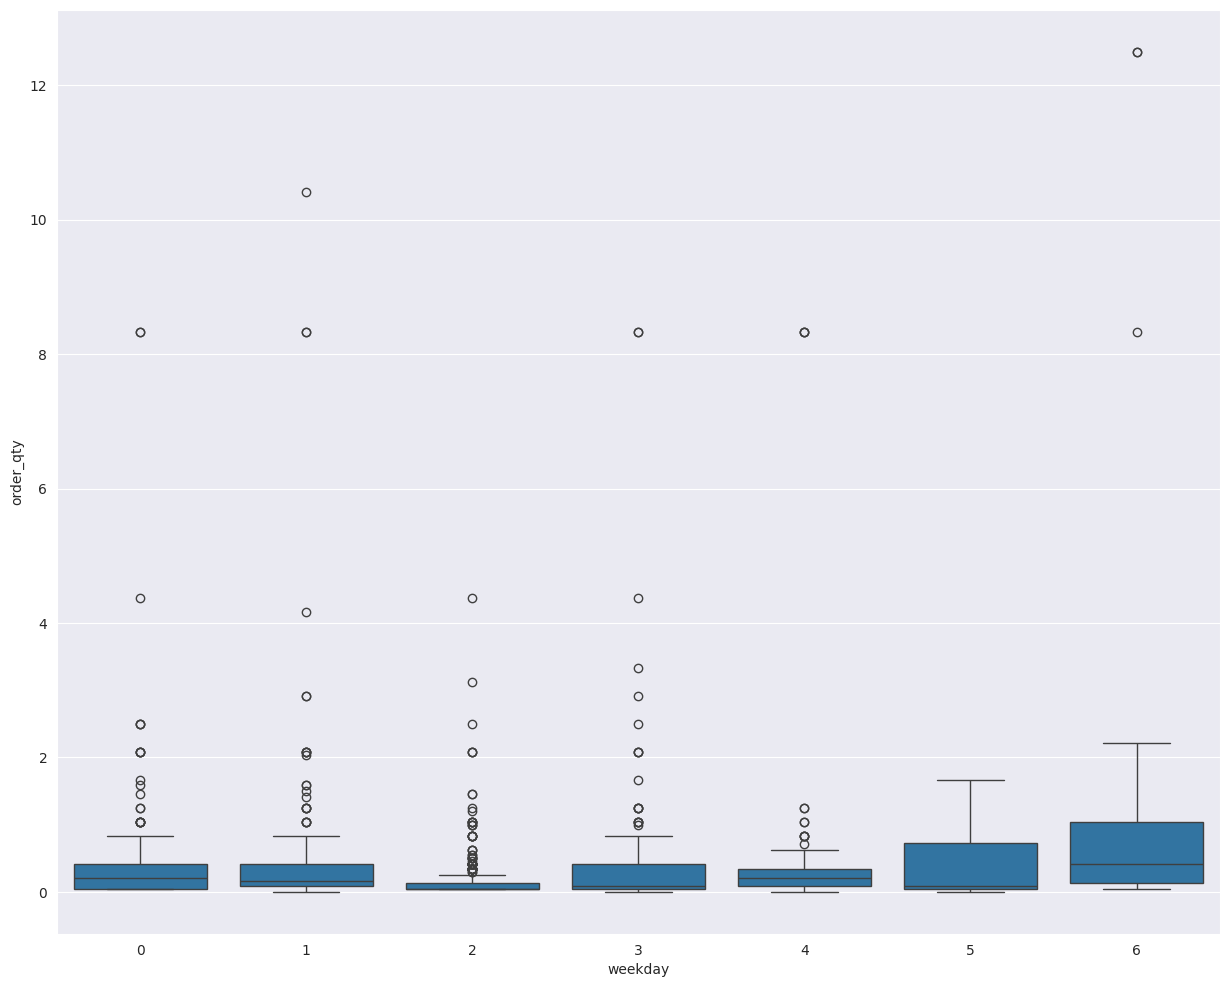

In [163]:
plt.figure(figsize=(15, 12))
sns.boxplot(x="weekday", y="order_qty", data=df_A1)

<Figure size 640x480 with 0 Axes>

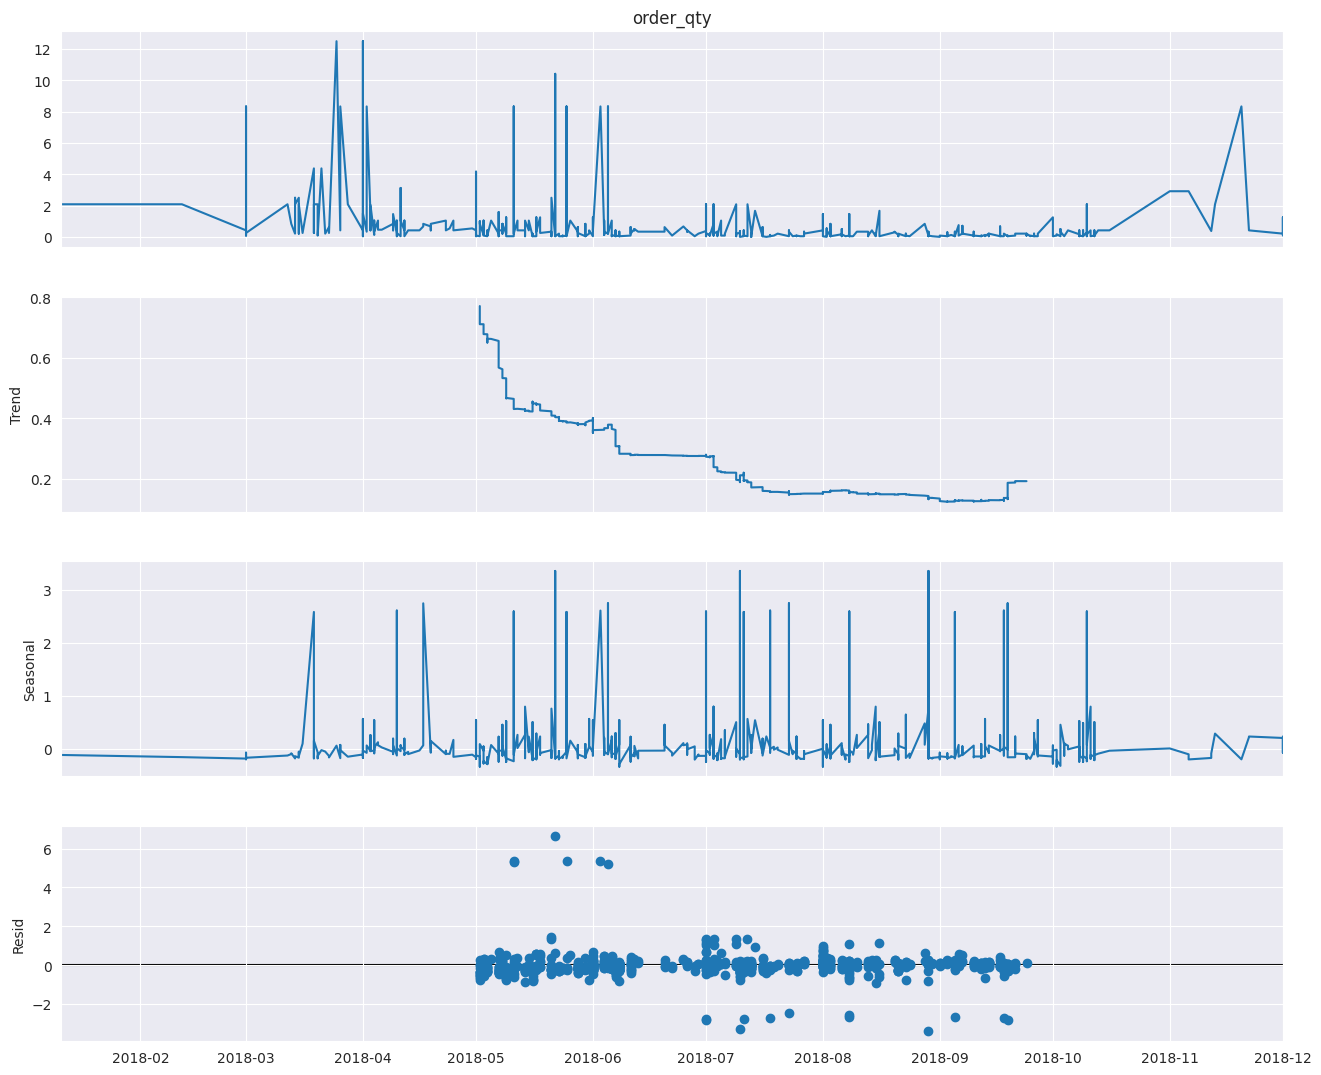

In [164]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df_A1['order_qty'], model='additive', period = 365)

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 12)

## Stationarize the data

In [165]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window = 12, cutoff = 0.01):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

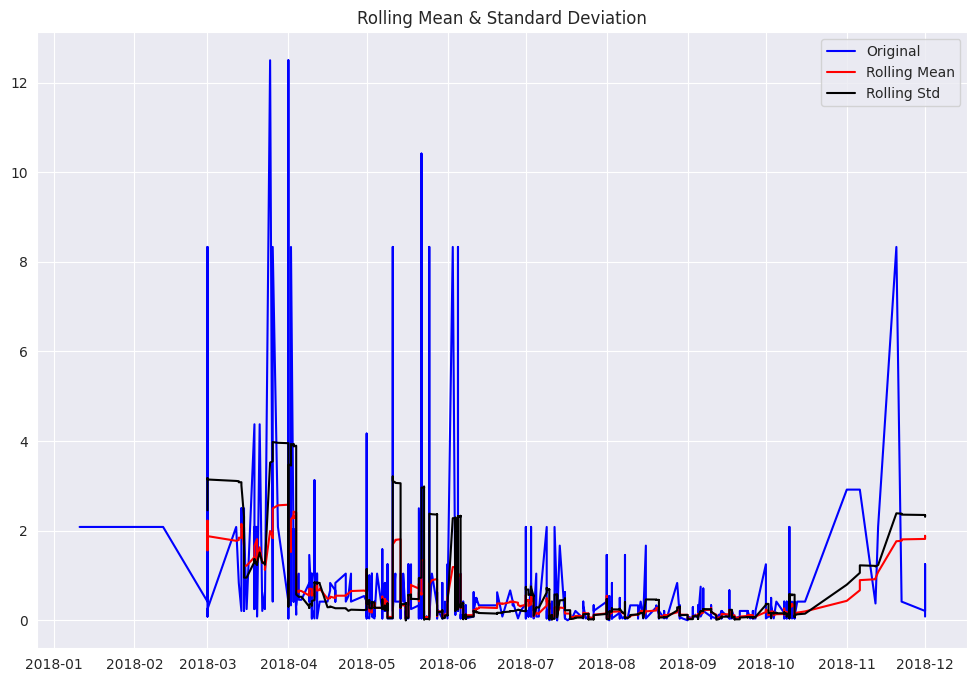

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -6.754947e+00
p-value                        2.887585e-09
#Lags Used                     1.400000e+01
Number of Observations Used    1.416000e+03
Critical Value (1%)           -3.434977e+00
Critical Value (5%)           -2.863583e+00
Critical Value (10%)          -2.567858e+00
dtype: float64


In [166]:
test_stationarity(df_A1['order_qty'])

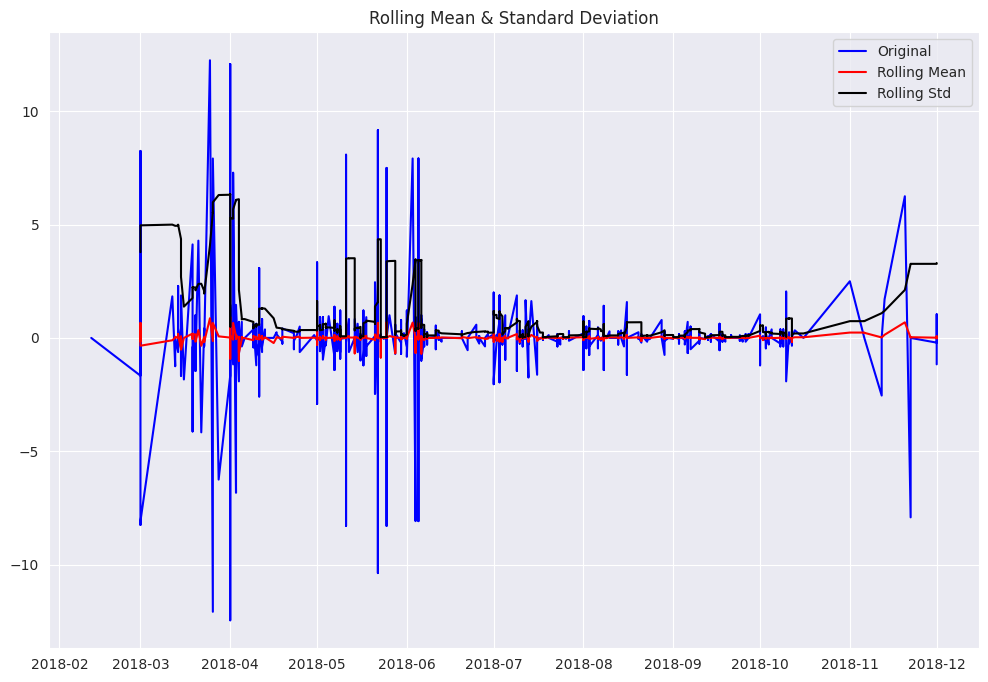

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -1.388891e+01
p-value                        6.018238e-26
#Lags Used                     2.000000e+01
Number of Observations Used    1.409000e+03
Critical Value (1%)           -3.435000e+00
Critical Value (5%)           -2.863593e+00
Critical Value (10%)          -2.567863e+00
dtype: float64


In [167]:
first_diff = df_A1.order_qty - df_A1.order_qty.shift(1)
first_diff = first_diff.dropna(inplace = False)
test_stationarity(first_diff, window = 12)

## ACF & PACF

The partial autocorrelation at lag k is the correlation that results after removing the effect of any correlations due to the terms at shorter lags.

Autoregression Intuition
Consider a time series that was generated by an autoregression (AR) process with a lag of k.

We know that the ACF describes the autocorrelation between an observation and another observation at a prior time step that includes direct and indirect dependence information.

This means we would expect the ACF for the AR(k) time series to be strong to a lag of k and the inertia of that relationship would carry on to subsequent lag values, trailing off at some point as the effect was weakened.

We know that the PACF only describes the direct relationship between an observation and its lag. This would suggest that there would be no correlation for lag values beyond k.

This is exactly the expectation of the ACF and PACF plots for an AR(k) process.

Moving Average Intuition
Consider a time series that was generated by a moving average (MA) process with a lag of k.

Remember that the moving average process is an autoregression model of the time series of residual errors from prior predictions. Another way to think about the moving average model is that it corrects future forecasts based on errors made on recent forecasts.

We would expect the ACF for the MA(k) process to show a strong correlation with recent values up to the lag of k, then a sharp decline to low or no correlation. By definition, this is how the process was generated.

For the PACF, we would expect the plot to show a strong relationship to the lag and a trailing off of correlation from the lag onwards.

Again, this is exactly the expectation of the ACF and PACF plots for an MA(k) process.

Summary
From the autocorrelation plot we can tell whether or not we need to add MA terms. From the partial autocorrelation plot we know we need to add AR terms.

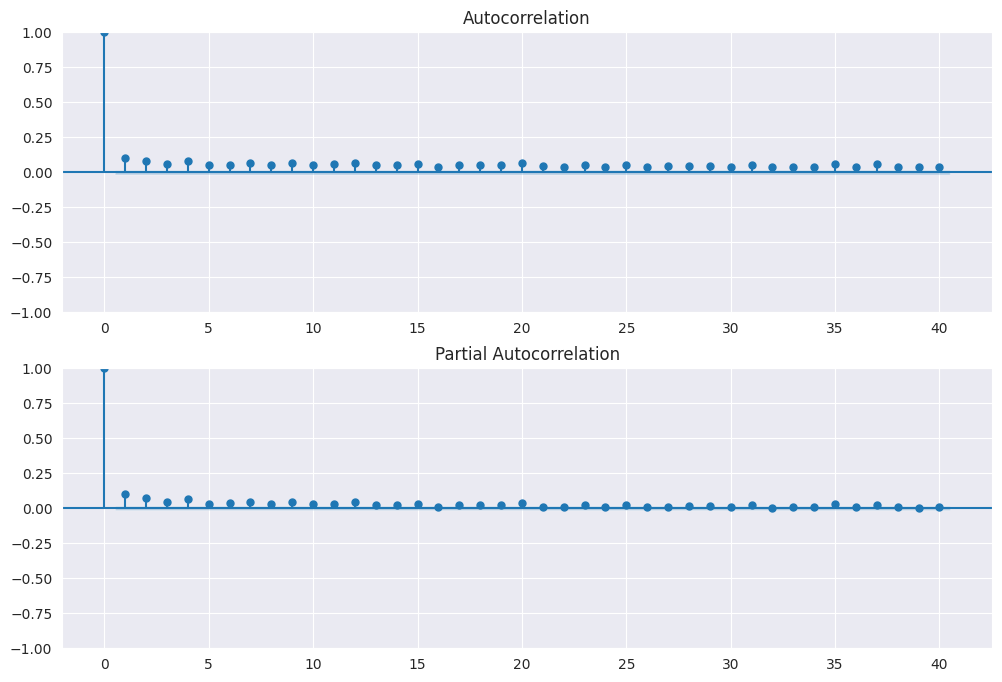

In [168]:
import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df.order_qty, lags=40, ax=ax1) # 
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df.order_qty, lags=40, ax=ax2)# , lags=40

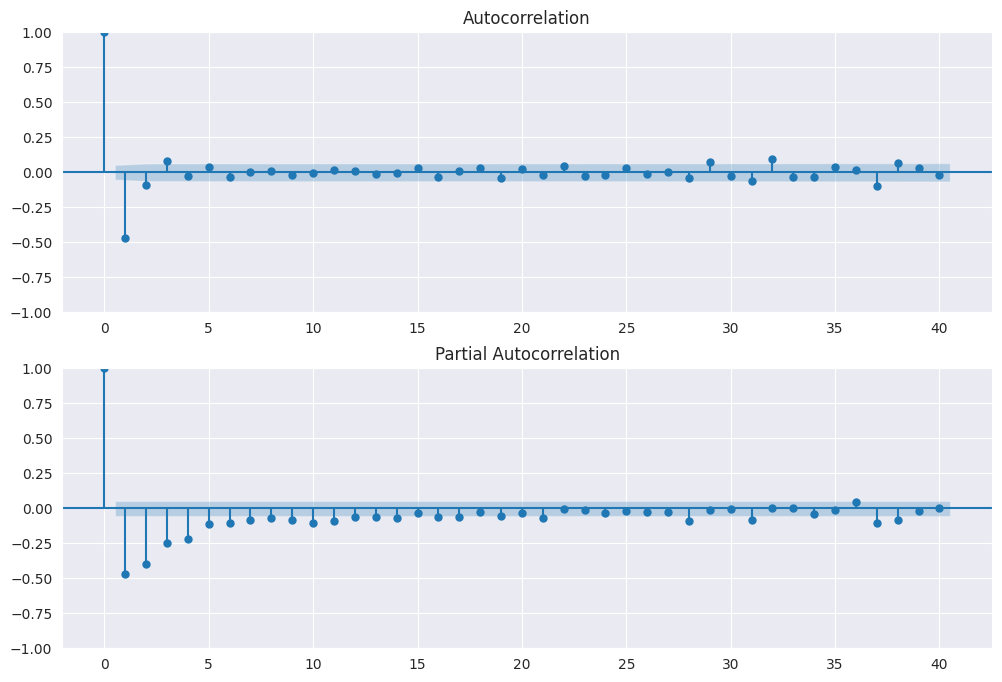

In [169]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(first_diff, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(first_diff, lags=40, ax=ax2)

Because the autocorrelation of the differenced series is negative at lag 7, 14, 21 etc.. (every week), I should an SMA term to the model.

Build the model

How to determin p, d, q
It's easy to determin I. In our case, we see the first order differencing make the ts stationary. I = 1.

AR model might be investigated first with lag length selected from the PACF or via empirical investigation. In our case, it's clearly that within 6 lags the AR is significant. Which means, we can use AR = 6

To avoid the potential for incorrectly specifying the MA order (in the case where the MA is first tried then the MA order is being set to 0), it may often make sense to extend the lag observed from the last significant term in the PACF.

What is interesting is that when the AR model is appropriately specified, the the residuals from this model can be used to directly observe the uncorrelated error. This residual can be used to further investigate alternative MA and ARMA model specifications directly by regression.

Assuming an AR(s) model were computed, then I would suggest that the next step in identification is to estimate an MA model with s-1 lags in the uncorrelated errors derived from the regression. The parsimonious MA specification might be considered and this might be compared with a more parsimonious AR specification. Then ARMA models might also be analysed.

In [170]:
arima_mod6 = sm.tsa.ARIMA(df_A1.order_qty, (0,1,0)).fit(disp=False)
print(arima_mod6.summary())

ValueError: endog and exog matrices are different sizes

In [ ]:
from scipy import stats
from scipy.stats import normaltest

resid = arima_mod6.resid
print(normaltest(resid))
# returns a 2-tuple of the chi-squared statistic, and the associated p-value. the p-value is very small, meaning
# the residual is not a normal distribution

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(resid)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')


# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arima_mod6.resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arima_mod6.resid, lags=40, ax=ax2)

NameError: name 'arima_mod6' is not defined

In [ ]:
# Plot for "Weekly" order
g = globals()

for product in df['product_id'].unique():
    g[f'df_{product}_w'] = g[f'df_{product}']['order_qty'].resample('w').mean()
    
# Create Matplotlib figure and axes
plt.figure(figsize=(10, 6))
plt.plot(df_A1_w.index, df_A1_w['order_qty'], label='Product A1')
plt.plot(df_B2_w.index, df_B2_w['order_qty'], label='Product B2')
plt.plot(df_C3_w.index, df_C3_w['order_qty'], label='Product C3')
plt.plot(df_D4_w.index, df_D4_w['order_qty'], label='Product D4')
plt.plot(df_E5_w.index, df_E5_w['order_qty'], label='Product E5')
plt.plot(df_F6_w.index, df_F6_w['order_qty'], label='Product F6')
plt.plot(df_G7_w.index, df_G7_w['order_qty'], label='Product G7')

# Customize the plot
plt.title('Order Quantity based on Product in Weekly')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()

# Show the plot
plt.show()

KeyError: 'order_qty'

<Figure size 1000x600 with 0 Axes>

In [ ]:
# Plot for "Weekly" order
g = globals()

for product in df['product_id'].unique():
    g[f'df_{product}_w'] = g[f'df_{product}']['order_qty'].resample('w').mean()
    
# Create Matplotlib figure and axes
plt.figure(figsize=(10, 6))
plt.plot(df_A1_w.index, df_A1_w['order_qty'], label='Product A1')
plt.plot(df_B2_w.index, df_B2_w['order_qty'], label='Product B2')
plt.plot(df_C3_w.index, df_C3_w['order_qty'], label='Product C3')
plt.plot(df_D4_w.index, df_D4_w['order_qty'], label='Product D4')
plt.plot(df_E5_w.index, df_E5_w['order_qty'], label='Product E5')
plt.plot(df_F6_w.index, df_F6_w['order_qty'], label='Product F6')
plt.plot(df_G7_w.index, df_G7_w['order_qty'], label='Product G7')

# Customize the plot
plt.title('Order Quantity based on Product in Weekly')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()

# Show the plot
plt.show()

KeyError: 'order_qty'

<Figure size 1000x600 with 0 Axes>

In [ ]:
# Plot for "Weekly" order
g = globals()

for product in df['product_id'].unique():
    g[f'df_{product}_w'] = g[f'df_{product}']['order_qty'].resample('w').mean()
    
# Create Matplotlib figure and axes
plt.figure(figsize=(10, 6))
plt.plot(df_A1_w.index, df_A1_w['order_qty'], label='Product A1')
plt.plot(df_B2_w.index, df_B2_w['order_qty'], label='Product B2')
plt.plot(df_C3_w.index, df_C3_w['order_qty'], label='Product C3')
plt.plot(df_D4_w.index, df_D4_w['order_qty'], label='Product D4')
plt.plot(df_E5_w.index, df_E5_w['order_qty'], label='Product E5')
plt.plot(df_F6_w.index, df_F6_w['order_qty'], label='Product F6')
plt.plot(df_G7_w.index, df_G7_w['order_qty'], label='Product G7')

# Customize the plot
plt.title('Order Quantity based on Product in Weekly')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()

# Show the plot
plt.show()

KeyError: 'order_qty'

<Figure size 1000x600 with 0 Axes>

In [ ]:
# Plot for "Weekly" order
g = globals()

for product in df['product_id'].unique():
    g[f'df_{product}_w'] = g[f'df_{product}']['order_qty'].resample('w').mean()
    
# Create Matplotlib figure and axes
plt.figure(figsize=(10, 6))
plt.plot(df_A1_w.index, df_A1_w['order_qty'], label='Product A1')
plt.plot(df_B2_w.index, df_B2_w['order_qty'], label='Product B2')
plt.plot(df_C3_w.index, df_C3_w['order_qty'], label='Product C3')
plt.plot(df_D4_w.index, df_D4_w['order_qty'], label='Product D4')
plt.plot(df_E5_w.index, df_E5_w['order_qty'], label='Product E5')
plt.plot(df_F6_w.index, df_F6_w['order_qty'], label='Product F6')
plt.plot(df_G7_w.index, df_G7_w['order_qty'], label='Product G7')

# Customize the plot
plt.title('Order Quantity based on Product in Weekly')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()

# Show the plot
plt.show()

KeyError: 'order_qty'

<Figure size 1000x600 with 0 Axes>

In [ ]:
# Plot for "Weekly" order
g = globals()

for product in df['product_id'].unique():
    g[f'df_{product}_w'] = g[f'df_{product}']['order_qty'].resample('w').mean()
    
# Create Matplotlib figure and axes
plt.figure(figsize=(10, 6))
plt.plot(df_A1_w.index, df_A1_w['order_qty'], label='Product A1')
plt.plot(df_B2_w.index, df_B2_w['order_qty'], label='Product B2')
plt.plot(df_C3_w.index, df_C3_w['order_qty'], label='Product C3')
plt.plot(df_D4_w.index, df_D4_w['order_qty'], label='Product D4')
plt.plot(df_E5_w.index, df_E5_w['order_qty'], label='Product E5')
plt.plot(df_F6_w.index, df_F6_w['order_qty'], label='Product F6')
plt.plot(df_G7_w.index, df_G7_w['order_qty'], label='Product G7')

# Customize the plot
plt.title('Order Quantity based on Product in Weekly')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()

# Show the plot
plt.show()

KeyError: 'order_qty'

<Figure size 1000x600 with 0 Axes>

In [76]:
# Plot for "Weekly" order
# Example DataFrame creation with datetime index
date_resample_w = df.resample('W').mean()

# Plotting
plt.figure(figsize=(10, 6))  # Optional: Set the figure size

# Plot the time series variable
plt.plot(date_resample_w.index, date_resample_w['order_qty'], marker='o', linestyle='-')

# Optional: Customize the plot (labels, title, etc.)
plt.xlabel('Date')
plt.ylabel('Time Series Variable')
plt.title('Time Series Plot')
plt.grid(True)  # Add grid
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Show the plot
plt.tight_layout()  # Optional: Adjust layout to prevent clipping of labels
plt.show()


TypeError: Cannot perform reduction 'mean' with string dtype

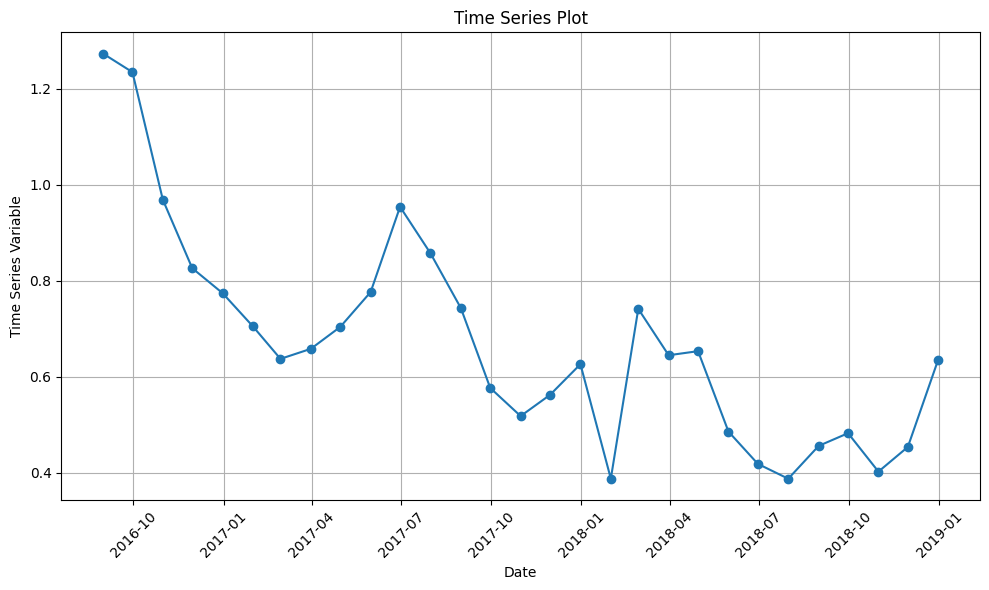

In [ ]:
# Plot for "Monthly" order
# Example DataFrame creation with datetime index
date_resample_m = df.resample('M').mean()

# Plotting
plt.figure(figsize=(10, 6))  # Optional: Set the figure size

# Plot the time series variable
plt.plot(date_resample_m.index, date_resample_m['order_qty'], marker='o', linestyle='-')

# Optional: Customize the plot (labels, title, etc.)
plt.xlabel('Date')
plt.ylabel('Time Series Variable')
plt.title('Time Series Plot')
plt.grid(True)  # Add grid
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Show the plot
plt.tight_layout()  # Optional: Adjust layout to prevent clipping of labels
plt.show()


#### Check lineplot order quantity for each product

In [ ]:
df['product_id'].unique()

array(['A1', 'B2', 'C3', 'D4', 'E5', 'F6', 'G7'], dtype=object)

In [33]:
# Split dataframe for each product_id
g = globals()

for product in df['product_id'].unique():
    g[f'df_{product}'] = df[df['product_id'] == product].sort_index()
    print(f'Total rows in df_{product} :', len(g[f'df_{product}']))

Total rows in df_A1 : 1431
Total rows in df_B2 : 3744
Total rows in df_C3 : 221
Total rows in df_D4 : 1355
Total rows in df_E5 : 9255
Total rows in df_F6 : 667
Total rows in df_G7 : 448


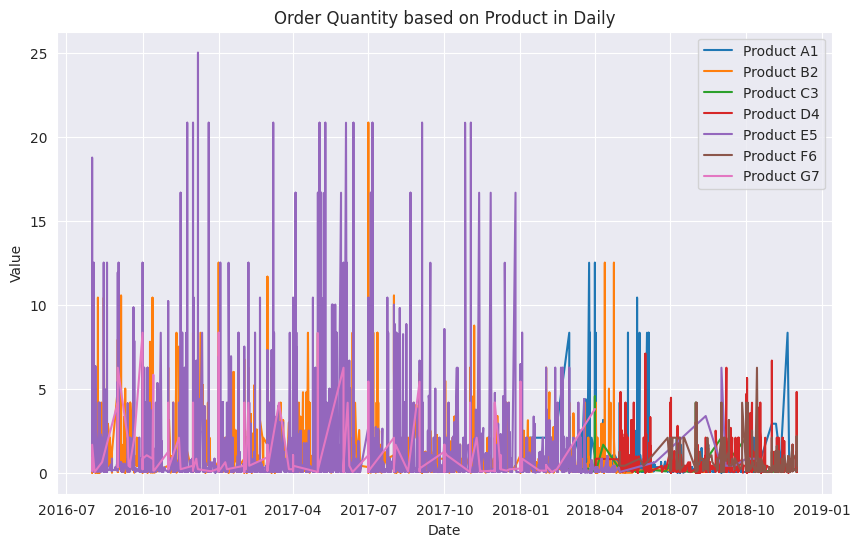

In [41]:
# Plot for "Daily" order
# Create Matplotlib figure and axes
plt.figure(figsize=(10, 6))
plt.plot(df_A1.index, df_A1['order_qty'], label='Product A1')
plt.plot(df_B2.index, df_B2['order_qty'], label='Product B2')
plt.plot(df_C3.index, df_C3['order_qty'], label='Product C3')
plt.plot(df_D4.index, df_D4['order_qty'], label='Product D4')
plt.plot(df_E5.index, df_E5['order_qty'], label='Product E5')
plt.plot(df_F6.index, df_F6['order_qty'], label='Product F6')
plt.plot(df_G7.index, df_G7['order_qty'], label='Product G7')

# Customize the plot
plt.title('Order Quantity based on Product in Daily')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()

# Show the plot
plt.show()

In [66]:
df_A1_w

date
2018-01-14    2.083333
2018-01-21         NaN
2018-01-28         NaN
2018-02-04         NaN
2018-02-11         NaN
2018-02-18    2.083333
2018-02-25         NaN
2018-03-04    1.952381
2018-03-11         NaN
2018-03-18    1.218750
2018-03-25    2.070312
2018-04-01    1.219697
2018-04-08    1.076754
2018-04-15    0.626488
2018-04-22    0.638889
2018-04-29    0.666667
2018-05-06    0.438763
2018-05-13    0.545775
2018-05-20    0.269737
2018-05-27    0.570685
2018-06-03    0.334325
2018-06-10    0.277778
2018-06-17    0.275463
2018-06-24    0.347222
2018-07-01    0.429924
2018-07-08    0.293860
2018-07-15    0.144426
2018-07-22    0.109195
2018-07-29    0.114286
2018-08-05    0.249413
2018-08-12    0.127604
2018-08-19    0.148649
2018-08-26    0.127976
2018-09-02    0.133333
2018-09-09    0.141892
2018-09-16    0.095833
2018-09-23    0.108871
2018-09-30    0.090278
2018-10-07    0.152146
2018-10-14    0.175000
2018-10-21    0.416667
2018-10-28         NaN
2018-11-04    2.916667
2018-1

In [61]:
# Plot for "Mothly" order
for product in df['product_id'].unique():
    g[f'df_{product}_m'] = g[f'df_{product}'].resample('M').mean()

# Create Matplotlib figure and axes
plt.figure(figsize=(10, 6))
plt.plot(df_A1_m.index, df_A1_m['order_qty'], label='Product A1')
plt.plot(df_B2_m.index, df_B2_m['order_qty'], label='Product B2')
plt.plot(df_C3_m.index, df_C3_m['order_qty'], label='Product C3')
plt.plot(df_D4_m.index, df_D4_m['order_qty'], label='Product D4')
plt.plot(df_E5_m.index, df_E5_m['order_qty'], label='Product E5')
plt.plot(df_F6_m.index, df_F6_m['order_qty'], label='Product F6')
plt.plot(df_G7_m.index, df_G7_m['order_qty'], label='Product G7')

# Customize the plot
plt.title('Order Quantity based on Product in Monthly')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()

# Show the plot
plt.show()

TypeError: Could not convert A1 to numeric

#### Check lineplot order quantity for each store

In [106]:
df['store'].unique()

<StringArray>
['7079', '7088', '7081', '7082', '7084']
Length: 5, dtype: string

In [ ]:
# Split dataframe for each store
g = globals()

for store in df['store'].unique():
    g[f'df_{store}'] = df[df['store'] == store].sort_index()
    print(f'Total rows in df_{store} :', len(g[f'df_{store}']))